In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append("..")
from audio import *

# FastAI Audio Features Notebook

First we quickly grab our dataset, a set of 10 speakers for speaker identification

In [20]:
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
data_folder = datapath4file(url2name(data_url))
if not os.path.exists(data_folder): untar_data(data_url, dest=data_folder)
audios = AudioList.from_folder(data_folder)

In [21]:
audios

AudioList (3842 items)
AudioItem 3.28 seconds (52480 samples @ 16000hz),AudioItem 4.4 seconds (70400 samples @ 16000hz),AudioItem 5.32 seconds (85120 samples @ 16000hz),AudioItem 3.36 seconds (53760 samples @ 16000hz),AudioItem 3.8 seconds (60800 samples @ 16000hz)
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS

# Preprocessing Features 

Preprocessing options currently consist of resampling, silence removal, and segmenting the clips, in that order. This happens when you label your items (e.g. call `label_from_folder()`). These actions can take several minutes, and possibly longer for large datasets, thus we automatically cache the results for you so that the process doesn't have to be repeated. This happens even if `cache_spectro=False` in your Config, that feature is for spectrogram caching only. This will allow you to try different configurations as quickly as possible. The caching happens at each stage, so if you change your settings for silence removal, the library will not need to repeat the resampling, but will instead pull the resampled files from the cache and resume silence removal.  

## Resampling

If you have multiple sample rates, you will have to resample to a single sample rate as your images won't be comparable (the time-axis (x-axis) of the spectrogram will have varied scales. 

Also you may sometimes want to resample from high sample rates to low sample rates. This will allow you to represent longer durations in the same space of a spectrogram (compressing the time axis). You can also achieve a similar effect by increasing the hop length of the spectrogram.

Keep in mind that by downsampling you will be throwing away any frequency information that is below 1/2 your sample rate. For example, at 16000hz, you will only be able to accurately represent frequencies 0-8000, so downsampling from 44100hz to 16000hz, you will lose information for frequencies in the range 8000hz-22050hz. For human voice this is okay, for music, it isn't. For more info read about Nyquist Theorem

**Resampling is as simple as setting the `resample_to` attribute of your config to the sample rate you want**, let's resample to 8000hz.

In [83]:
!rm -rf {str(data_folder / '.cache')}


In [48]:
%%time
config = AudioConfig()
config.resample_to = 8000
rs_audio = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]


CPU times: user 51.8 s, sys: 768 ms, total: 52.5 s
Wall time: 13.3 s


In [49]:
rs_audio

LabelLists;

Train: AudioLabelList (3074 items)
x: AudioList
AudioItem 3.28 seconds (26240 samples @ 8000hz),AudioItem 4.4 seconds (35200 samples @ 8000hz),AudioItem 3.36 seconds (26880 samples @ 8000hz),AudioItem 3.8 seconds (30400 samples @ 8000hz),AudioItem 2.92 seconds (23360 samples @ 8000hz)
y: CategoryList
f0004,m0002,f0001,f0005,m0005
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS;

Valid: AudioLabelList (768 items)
x: AudioList
AudioItem 2.48 seconds (19840 samples @ 8000hz),AudioItem 7.2 seconds (57600 samples @ 8000hz),AudioItem 5.48 seconds (43840 samples @ 8000hz),AudioItem 2.52 seconds (20160 samples @ 8000hz),AudioItem 2.76 seconds (22080 samples @ 8000hz)
y: CategoryList
f0002,m0003,f0005,m0005,f0004
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS;

Test: None

Note that we have the same number of files, but they've all been resampled to 8000hz.

For efficiency we use a polyphase resampling method instead of FFT-based. This will be faster except in rare cases where the greatest common denominator of the old sample rate and the new sample rate is low (< 20). Since we mostly use round numbers, this doesn't tend to happen, but if you suddenly decide to resample to a prime sample rate, you may seem your time balloon upward. 

Remember we are caching so while it took ~13 seconds to resample the first time, creating a new LabelList with the same settings and data will be nearly instant

In [51]:
%%time
config = AudioConfig()
config.resample_to = 8000
rs_audio = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

CPU times: user 228 ms, sys: 32 ms, total: 260 ms
Wall time: 259 ms


## Silence Removal

Sometimes we have a dataset that is full of lengthy clips with lots of silence. A real world example is a marine biologist trying to identify whale calls in a recording. Most of the recording will be silence, along with some occasional noise that we need to classify (call or not a call). It would be helpful to remove the silence and split the clip into separate files with each noise so that we can build a classifier. 

If you set `config.remove_silence` to `True`, during preprocessing the clip will be segmented at any point where there is 2*`config.silence_padding` ms or more of silence, as defined by `config.silence_threshold` in decibels. Each segmented clip will keep some of the silence as it may be useful. 

In [25]:
config.remove_silence = True

In [26]:
config.remove_silence, config.silence_padding, config.silence_threshold

(True, 200, 20)

In [27]:
config.silence_threshold=20

In [28]:
label_pattern = r'_([mf]\d+)_'
audio_labellist = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

In [33]:
audios.train[0][0].path

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache/sh_20-200/0.wav-3ff0fe11d974b25776669c87fe19286e/0.wav')

## Segmentation

Segmentation will chop your clips up into equal intervals for you. 

# Generating Images from Audio

Using raw audio with deep neural nets is promising, but has had mixed results and is much more expensive to train. The vast majority of models use a spectral extraction of the audio rather than the raw audio itself. The most common is the melspectrogram (If you don't know what a spectrogram or the mel-scale are, please see the Intro to Audio notebook)

In [53]:
#turn preprocessing off and just use normal data
config.resample_to = None
config.remove_silence = False
config.segment_size = None
audios = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

## Spectrogram Generation

The library will automatically create melspectrograms for you on the fly, transform them, and train. To do this you just need to set use_spectro = True. 

You can deactivate this warning by passing `no_check=True`.
------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py:269: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 128, 109]), torch.Size([3, 128, 152]), torch.Size([3, 128, 52]), torch.Size([3, 128, 96]), torch.Size([3, 128, 173]), torch.Size([3, 128, 168]), torch.Size([3, 128, 113]), torch.Size([3, 128, 168]), torch.Size([3, 128, 158]), torch.Size([3, 128, 89]), torch.Size([3, 128, 166]), torch.Size([3, 128, 117]), torch.Size([3, 128, 99]), torch.Size([3, 128, 123]), torch.Size([3, 128, 174]), torch.Size([3, 128, 97]), torch.Size([3, 128, 114]), torch.Size([3, 128, 199]), torch.Size([3, 128, 184]), torch.Size([3, 128, 109]), torch.Size([3, 128, 228]), torch.Size([3, 128, 187]), torch.Size([3, 128, 133]), torch.Size([3, 128, 126]), torch.Size([3, 128, 173]), torch.Size([3, 128, 146]), torch.Size([3, 128, 157]), torch.Size([3, 128, 172]), torch.Size([3, 128, 97]), torch.Size([3, 128, 137]), torch.Si

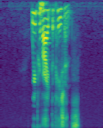

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002


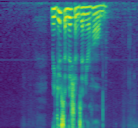

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


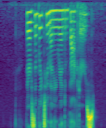

In [57]:
#use spectrograms (this by default is true, and currently there is no real way to use raw audio)
config.use_spectro = True
db = audios.databunch(bs=64)
db.show_batch()

As you can see we are generating spectrograms, but they are unequal widths, because of the varying durations of the audio. As mentioned in the Getting Started guide, you can fix this by either setting `max_to_pad` or `duration` (both are how long you want clips to be in ms). Duration should train better in almost all cases. Let's try both to see the differences. 

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


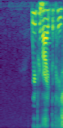

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002


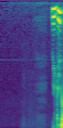

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


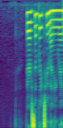

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Label: f0005


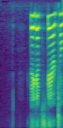

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav
Label: m0005


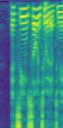

In [75]:
config.max_to_pad = 2000
config.duration = None
audios = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_max_to_pad = audios.databunch(bs=64)
db_max_to_pad.show_batch(5)

With `max_to_pad` the shorter clips are padded with zeros and the longer ones are cropped taking the first 4000ms of audio. `duration` will perform better because instead of taking just the first 4000ms of audio, it will take the equivalent of 4000ms at random from the spectrogram and will not throw away any data. This will be more and more important the lower you set `duration`/`max_to_pad`, or the more variation of audio length in your dataset there is

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004
0.99s-2.99s of original clip


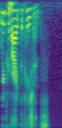

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.58s-2.58s of original clip


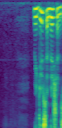

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001
1.12s-3.12s of original clip


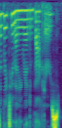

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Label: f0005
1.47s-3.47s of original clip


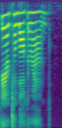

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav
Label: m0005
0.67s-2.67s of original clip


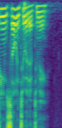

In [79]:
config.max_to_pad = None
config.duration = 2000
audios = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_max_to_pad = audios.databunch(bs=64)
db_max_to_pad.show_batch(5)

Note that duration will also tell you which part of the clip you're listening to and seeing, and it will be different every time you look at an item

## Mel-Frequency Cepstral Coefficients

Mel frequency cepstral coefficients are a form of audio extraction used in speech/voice recognition. They can train to pretty high degrees of accuracy extremely quickly, but given the limited amount of data they provide to the model, they often underperform melspectrograms in our testing.

Trying them out is fast and easy, just set `config.mfcc = True`, and your melspectrogram will be replaced by an mfcc.

In [106]:
config.duration = 4000
config.mfcc = True
audios = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_mfcc = audios.databunch(bs=64)
db_mfcc.show_batch(5)


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.22s-4.22s of original clip


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Label: f0005


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav
Label: m0005


In [ ]:
learn = audio_learner(db_mfcc)
learn.lr_find(); learn.recorder.plot()

In [102]:
learn.fit_one_cycle(5, slice(7e-3, 7e-2))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


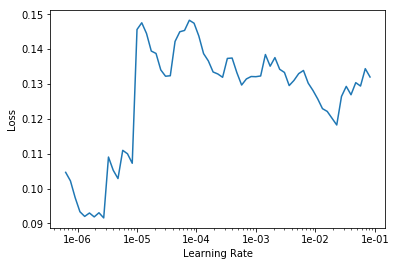

In [103]:
learn.lr_find(); learn.recorder.plot()

In [104]:
learn.fit_one_cycle(10, slice(1e-3))

## Delta and Acceleration Stacking

Delta and acceleration appending/stacking is something you'll see often in ML papers. To reproduce, just set `delta=True` and the 2nd and 3rd channel of your image will be the delta and accelerate.

In [107]:
config.delta = True
audios = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)
db_mfcc_stack = audios.databunch(bs=64)
db_mfcc_stack.show_batch(5)


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.13s-4.13s of original clip


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Label: f0005


------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav
Label: m0005


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


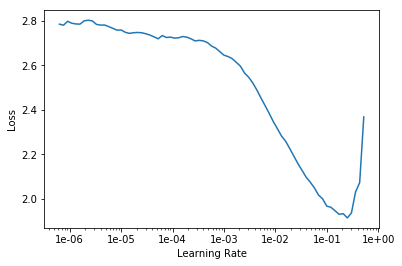

In [110]:
learn = audio_learner(db_mfcc_stack)
learn.lr_find(); learn.recorder.plot()

In [111]:
learn.fit_one_cycle(10, slice(7e-3, 7e-2))

## Caching

Spectrogram generation is done through TorchAudio, but even optimized for torch, discrete fourier transforms are slow (several ms per item) and are a time bottleneck. Read/write from disk is almost always faster, so we offer the option to cache files (.pt files, saved torch tensors). If you set `cache_spectro = True`, your spectrograms will be saved to `cache_folder` inside of the same folder where your data is stored. You shouldn't need to change this, and the current implementation is a bit rigid, so you can only choose the subfolder of your datafolder where it is located, you cannot currently choose a location outside of that folder. It is set by default to be '.cache' 

Note that for large datasets this can be potentially huge amounts of data (~20-50GB) so if you are working with a large dataset you may want to clear the cache each time you change settings. We currently don't off 

In [115]:
config.cache_dir

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/.cache')

Files that start with a . are hidden in Linux, so if you're searching in the terminal you may need to type `ls -a`.

In [128]:
! ls {config.cache_dir}

6371d384c312824a26243b7ae2fb031a  9ada91b269d7cfe1f093baa51ad289f8  s_1000
7cd1afb76795744c0c8ebd6ce3623e7e  rs_8000			    sh_20-200


The spectrograms are stored in a folder with the hash of the set of settings you used. The preprocessing is stored in it's own folder. rs_8000 is resample to 8000, sh_20-200 is silence removal with a threshold of 20dB and padding 200ms, and s_1000 is segment into 1000ms chunks. 

# Transforms

## Frequency Masking

## Time Masking

## Rolling 

## Mixup

## Audio Configuration

All config settings are managed through an `AudioConfig object`. It also contains within it a `SpectrogramConfig` object that holds settings related to spectrograms and MFCC (mel-frequency cepstral coefficients). The inner config can be changed just like the outer one by nesting. `config.sg_cfg.top_db=80` for instance

In [14]:
config = AudioConfig()
config

AudioConfig(cache=True, duration=None, max_to_pad=None, remove_silence=False, use_spectro=True, mfcc=False, delta=False, silence_padding=200, silence_threshold=20, segment_size=None, resample_to=None, standardize=False, sg_cfg=SpectrogramConfig(f_min=0, f_max=8000, hop=512, n_fft=2560, n_mels=128, pad=0, to_db_scale=True, top_db=100, ws=None, n_mfcc=20))

As you can see there are tons of features here, most of which you will not need to adjust to get pretty good results. If you plan on doing a lot of work on audio, or have a dataset with lots of silence, or a wide variety of audio lengths, check out our **Features Notebook** in the example folder, it shows when and how to adjust each of these settings.

For now we will only cover the most essential features `resample_to`, `max_to_pad` and `duration`

### `max_to_pad` and `duration`

Eventually, our audio will become spectrograms (visual representations of audio that can be passed to an image classifier). 
Like images, it is important that our spectrograms be the same size so that the GPU can handle them efficiently. Since audio clips rarely have precisely equal length, we give you two options for generating fixed width spectrograms. Which one is best for you will depend on the nature of your data.

1. Specify the `duration` setting of your config. This will compute the spectrogram using the entire clip regardless of length, but at train time will grab random sections that are `duration` milliseconds long. If duration is greater than the length of the clip, it will pad your spectrogram with zeroes to be the same length as the others. 

2. Set the `max_to_pad` attribute of your config (in milliseconds) the end audio should be. This will pad or clip the underlying audio, and then generate spectrograms from that audio. It will zero-pad clips that are too short, and trim clips that are too long, throwing away the remaining data. 

For this dataset, let's use duration so we don't throwaway data from the longer clips, and let's use 4000ms (4s). 

In [15]:
config.duration = 4000

### `resample_to`

Also it is important that all of the data is the same sample rate. If one spectrogram has a sample rate of 44100, and another's is 16000, the x-axis of the spectrogram will represent different amounts of time, and thus they won't be comparable. So if you see more than one sample rate when you call the `.stats()` method above, you will need to set `resample_to` to be an int representing the sample rate you wish to use. It is best practice to use common sample rates (44100, 22050, 16000 or 8000) as they will be faster to resample. 

For our data, there is no need to resample, but if we did, the code to downsample to 8000 would just be `config.resample_to=8000`

## Creating a databunch

Now we follow the normal fastai datablock API, making sure to pass our config to the AudioList

In [17]:
label_pattern = r'_([mf]\d+)_'
audios = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

Fastai Audio performs on the fly data augmentation directly on spectrograms. Try uncommenting the second line and playing around with the transform manager and for more detail check out the Features Notebook

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav
Label: f0004


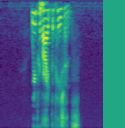

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav
Label: m0002
0.29s-4.29s of original clip


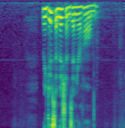

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav
Label: f0001


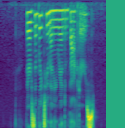

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Label: f0005


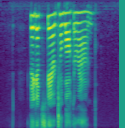

------------------------------------------------------------
File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav
Label: m0005


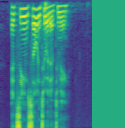

In [20]:
tfms = None
#tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
db = audios.transform(tfms).databunch(bs=64)
db.show_batch(5)

When audio is longer than the duration you've selected for training, it is clipped at random, but those items will tell you what time portion of the original audio clip the spectrogram and displayed audio represent. It will appear as '2.53s-6.53s of original clip'. Clips that are shorter than duration are padded with zeros, this will appear as a blue-green bar on the right hand side of the spectrogram

# Learner

An Audio learner takes a databunch, base_arch(optional, defaults to resnet18 for now), and metrics(optional, defaults to accuracy) and returns a cnn_learner. For now it is just a wrapper, but additional functionality is coming soon. 

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Acknowledgements

This library builds on the work of many others. It is of course built on top of fastai, so thank you to **Jeremy, Rachel, Stas, Sylvain** and countless others. It is a fork of https://github.com/zcaceres/fastai-audio and so we owe a lot to **@aamir7117 @marii @simonjhb @ste @ThomM @zachcaceres**. And it is built on top of torchaudio which helps us do things many things much faster than would otherwise be possible. Thanks as well to those who have been active in the [fastai audio thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123). 

Finally thanks to **@baz** and **@MadeUpMasters** for implementing and maintaining the library. 

# FastAI Audio

This notebook will show you the fastest way to get started with FastAI audio. In the `examples` folder, we have included a number of other notebooks that show more features, and teach you about audio in general. If you'd like to follow along in a colab notebook, please click [here](https://colab.research.google.com/drive/1s0Ouw5PxvrmHdm_gBU0qiA6piOf3VSWO) and copy this into your own google drive.

First, import fastai audio, this will import all the dependecies you will need to work with Audio.

from audio import *

## AudioItem

Here we create an `AudioItem` to load an audio file and listen to it by passing the filename (either `str` or `PosixPath`) to `AudioItem.open()`, we can also see some information about the audio.

path_example = Path('data/Right_whale.wav')
sound = AudioItem.open(path_example)
sound

This clip is 87.73 seconds long. Audio is a continuous wave that is "sampled" by measuring the amplitude of the wave at a given point in time. How many times you sample per second is called the "sample rate" and can be thought of as the resolution of the audio. In our example, the audio was sampled 44100 times per second, so our data is a rank 1 tensor with length 44100*time in seconds = 3869019 samples. 

If any of this is new to you, definitely check out our **Intro to Audio Notebook** in the `examples` folder.

sound.shape

### Important attributes inside of an AudioItem

#sig means signal, it's a rank one tensor with the amplitudes sampled from the raw sound wave
sound.sig

#sr means sample rate
sound.sr

#path is a reference to the location of the sound file
sound.path

## AudioList and Speaker Recognition Example

We'll work with a fairly small dataset that has 10 speakers, 5 male and 5 female, with the goal of recognizing who is speaking.

We can download the data into our default fastai data directory

data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest=data_folder)

We first create an AudioList. This extends fastai ItemList so you can use other methods like `from_csv()` to load your data as well

audios = AudioList.from_folder(data_folder)

Because audio data can be so variable, we provide a convenience function `.stats()` that will display a list of sample rates, and how many files have that sample rate, as well as a plot of the lengths, in seconds, of the audio files in your `AudioList`. You can also specify `prec` to set the number of digits the file lengths are rounded to before plotting the graph (default is 0). Expect it to take about 2 seconds per 5000 files in your dataset

audios.stats(prec=1)

In this dataset, there is only one sample rate. If you have multiple sample rates, you will need to resample to a single sample rate by setting `resample_to` in the configuration settings. If you want to do any customization, you'll need to pass a config object to the AudioList constructor, so before we go any further, here's how to use it.

## Audio Configuration

All config settings are managed through an `AudioConfig object`. It also contains within it a `SpectrogramConfig` object that holds settings related to spectrograms and MFCC (mel-frequency cepstral coefficients). The inner config can be changed just like the outer one by nesting. `config.sg_cfg.top_db=80` for instance

config = AudioConfig()
config

As you can see there are tons of features here, most of which you will not need to adjust to get pretty good results. If you plan on doing a lot of work on audio, or have a dataset with lots of silence, or a wide variety of audio lengths, check out our **Features Notebook** in the example folder, it shows when and how to adjust each of these settings.

For now we will only cover the most essential features `resample_to`, `max_to_pad` and `duration`

### `max_to_pad` and `duration`

Eventually, our audio will become spectrograms (visual representations of audio that can be passed to an image classifier). 
Like images, it is important that our spectrograms be the same size so that the GPU can handle them efficiently. Since audio clips rarely have precisely equal length, we give you two options for generating fixed width spectrograms. Which one is best for you will depend on the nature of your data.

1. Specify the `duration` setting of your config. This will compute the spectrogram using the entire clip regardless of length, but at train time will grab random sections that are `duration` milliseconds long. If duration is greater than the length of the clip, it will pad your spectrogram with zeroes to be the same length as the others. 

2. Set the `max_to_pad` attribute of your config (in milliseconds) the end audio should be. This will pad or clip the underlying audio, and then generate spectrograms from that audio. It will zero-pad clips that are too short, and trim clips that are too long, throwing away the remaining data. 

For this dataset, let's use duration so we don't throwaway data from the longer clips, and let's use 4000ms (4s). 

config.duration = 4000

### `resample_to`

Also it is important that all of the data is the same sample rate. If one spectrogram has a sample rate of 44100, and another's is 16000, the x-axis of the spectrogram will represent different amounts of time, and thus they won't be comparable. So if you see more than one sample rate when you call the `.stats()` method above, you will need to set `resample_to` to be an int representing the sample rate you wish to use. It is best practice to use common sample rates (44100, 22050, 16000 or 8000) as they will be faster to resample. 

For our data, there is no need to resample, but if we did, the code to downsample to 8000 would just be `config.resample_to=8000`

## Creating a databunch

Now we follow the normal fastai datablock API, making sure to pass our config to the AudioList

label_pattern = r'_([mf]\d+)_'
audios = AudioList.from_folder(data_folder, config=config).split_by_rand_pct(.2, seed=4).label_from_re(label_pattern)

Fastai Audio performs on the fly data augmentation directly on spectrograms. Try uncommenting the second line and playing around with the transform manager and for more detail check out the Features Notebook

tfms = None
#tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
db = audios.transform(tfms).databunch(bs=64)
db.show_batch(5)

When audio is longer than the duration you've selected for training, it is clipped at random, but those items will tell you what time portion of the original audio clip the spectrogram and displayed audio represent. It will appear as '2.53s-6.53s of original clip'. Clips that are shorter than duration are padded with zeros, this will appear as a blue-green bar on the right hand side of the spectrogram

# Learner

An Audio learner takes a databunch, base_arch(optional, defaults to resnet18 for now), and metrics(optional, defaults to accuracy) and returns a cnn_learner. For now it is just a wrapper, but additional functionality is coming soon. 